## Group Project Title: Anlysis of Blue Voters in Red States

Group Members: Joseph Chang, Grant Cai, Chen Guo

In [9]:
from pyspark.sql import SparkSession
import pyspark as ps
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum, col, desc

In [10]:
# CHANGE YOUR FILE HERE
file = "gs://pstat135-chen/notebooks/jupyter/project data/VM2Uniform--AL--2021-02-04.tab"

#### Import Datasets

In [ ]:
# read in the .tab as a csv file
df = spark.read.format("csv").option("header",
    "true").option("nullValue", "NA").option("delimiter", "\t").option(
    "inferSchema", "true").load(file)

23/03/03 22:17:31 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/03/03 22:17:46 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/03/03 22:18:01 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/03/03 22:18:16 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


## Question that we are trying to answer:

Republican states, or "red" states are defined as having a majority of the population voting for the Republican party. However, observations of these "red states" have found that the most prominent and most populous cities are actually mostly "blue", or voting for Democratic. We want to know if for every active voter, what is the voter turnout in the the big cities belonging to these "red" states and perhaps if it can be determined whether and why these populous cities will be blue. We also want to see which party these same voters belong to. We will analyze every presidential elections from 2000 to 2016.

## The exploratory phase 

Since there are many states to choose from, we will select states in the Southern region of the United States, most notably Texas, Alabama, and Georgia. For each of these states, we will choose some columns such as Voter_Gender, Voter_Age, Voters_Active, and then remove null values for each of the columns.

#### Calculate Missing Percents

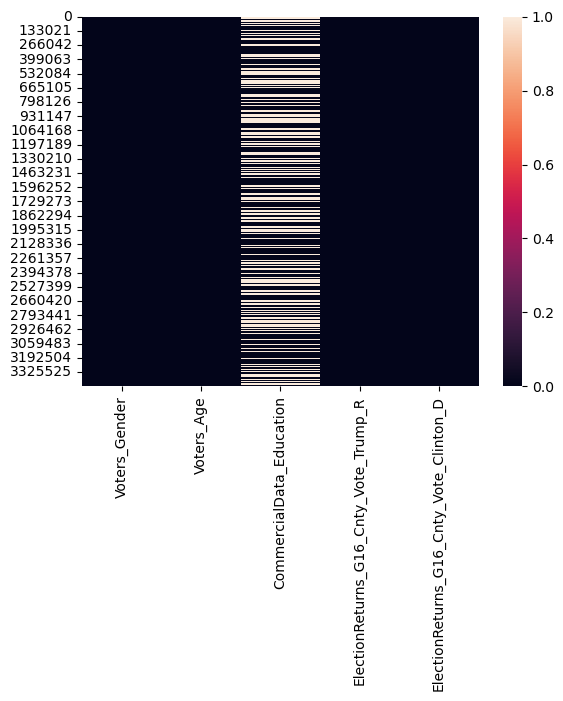

In [4]:
na = df.select('Voters_Gender','Voters_Age',\
                   'CommercialData_Education','ElectionReturns_G16_Cnty_Vote_Trump_R','ElectionReturns_G16_Cnty_Vote_Clinton_D')
na_map = na.toPandas()

tf_na = na_map.isnull()

sns.heatmap(data=tf_na)
plt.xticks(rotation = 90, fontsize = 10)
plt.yticks(rotation = 0, fontsize = 10)
plt.show();

Here, we wanted to see how many null values were in each column. We see that only CommercialData_Education has missing values.

#### Drop Missing Value 

In [5]:
data = df.select('Voters_Gender', 'Voters_Age',\
                'CommercialData_Education','ElectionReturns_G16_Cnty_Vote_Trump_R','ElectionReturns_G16_Cnty_Vote_Clinton_D')\
.na.drop(subset = ['Voters_Gender','Voters_Age','CommercialData_Education','ElectionReturns_G16_Cnty_Vote_Trump_R','ElectionReturns_G16_Cnty_Vote_Clinton_D'])


#### Display the Data

In [6]:
data.show(10)
print('Total Records in dataset',data.count())

+-------------+----------+------------------------+-------------------------------------+---------------------------------------+
|Voters_Gender|Voters_Age|CommercialData_Education|ElectionReturns_G16_Cnty_Vote_Trump_R|ElectionReturns_G16_Cnty_Vote_Clinton_D|
+-------------+----------+------------------------+-------------------------------------+---------------------------------------+
|            F|        47|     HS Diploma - Likely|                                18172|                                   5936|
|            F|        53|    HS Diploma - Extr...|                                18172|                                   5936|
|            F|        60|     HS Diploma - Likely|                                18172|                                   5936|
|            M|        30|     HS Diploma - Likely|                                18172|                                   5936|
|            F|        24|    Some College - Li...|                                18172| 

Total Records in dataset 2083910


#### Count the number of people per education level

We will sort the education level column so we can group together and count the number of people per group.

In [7]:
edu = data.groupby('CommercialData_Education').count().sort(desc('count'))
edu.show()

+------------------------+------+
|CommercialData_Education| count|
+------------------------+------+
|    Some College - Li...|379198|
|    HS Diploma - Extr...|371870|
|    Bach Degree - Ext...|369955|
|     HS Diploma - Likely|286480|
|    Bach Degree - Likely|163518|
|    Grad Degree - Ext...|151805|
|    Less than HS Dipl...|134428|
|    Grad Degree - Likely|111082|
|    Some College -Ext...|109899|
|    Vocational Techni...|  4449|
|    Less than HS Dipl...|  1226|
+------------------------+------+



/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


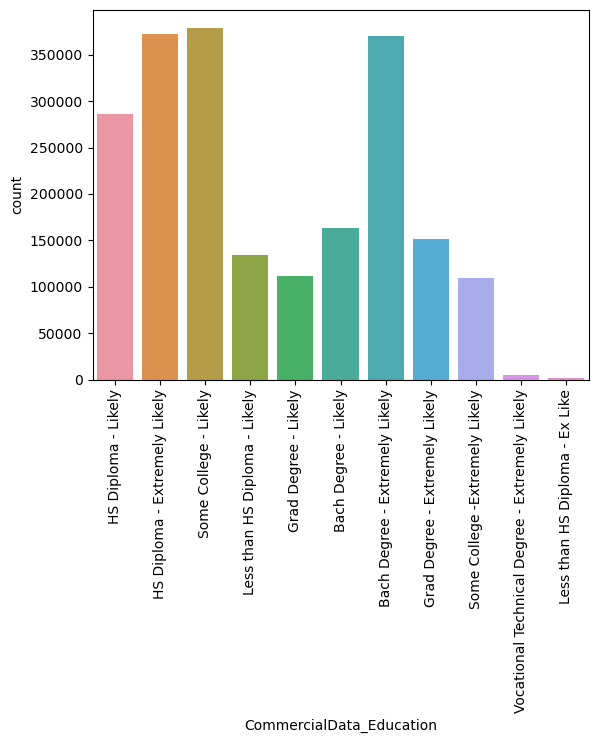

In [8]:
edu1 =data.toPandas()
sns.countplot(edu1['CommercialData_Education'])
plt.xticks(rotation = 90, fontsize = 10)
plt.show()

Here, we can see that the *Some College - Likely* has the highest proprotion of `CommercialData_Education` in our state dataset.

#### Create a Bar graph of the number of votes for each party per county

In [9]:
df1 = df.select("County","ElectionReturns_G16_Cnty_Vote_Trump_R",'ElectionReturns_G16_Cnty_Vote_Clinton_D').distinct()
df1.show()

+--------+-------------------------------------+---------------------------------------+
|  County|ElectionReturns_G16_Cnty_Vote_Trump_R|ElectionReturns_G16_Cnty_Vote_Clinton_D|
+--------+-------------------------------------+---------------------------------------+
| BALDWIN|                                72883|                                  18458|
| BARBOUR|                                 5454|                                   4871|
|  BUTLER|                                 4901|                                   3726|
| BULLOCK|                                 1140|                                   3530|
| CALHOUN|                                32865|                                  13242|
|CHAMBERS|                                 7843|                                   5784|
|CHEROKEE|                                 8953|                                   1547|
|  CLARKE|                                 7140|                                   5749|
| CHOCTAW|           

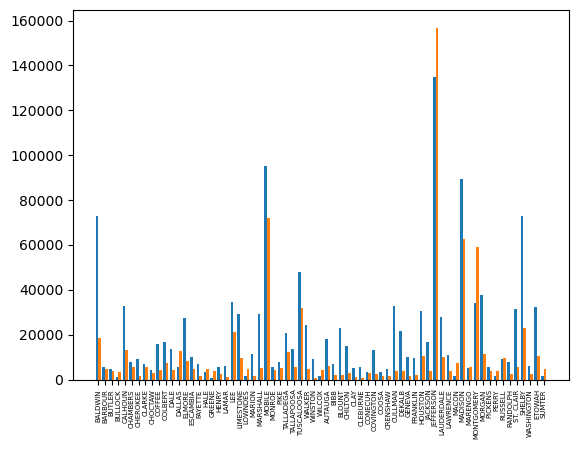

In [10]:
Voter = df1.toPandas()
X = Voter['County']
Yrep = Voter['ElectionReturns_G16_Cnty_Vote_Trump_R']
Ydem = Voter['ElectionReturns_G16_Cnty_Vote_Clinton_D']

Xaxis = np.arange(len(X))

plt.bar(Xaxis-0.2, Yrep, 0.4, label = 'Republican votes')
plt.bar(Xaxis+0.2, Ydem, 0.4, label = 'Democratic votes')
plt.xticks(Xaxis, X, rotation = 90, fontsize = 5);

Here, we are looking at the columns: ElectionReturns_G16_Cnty_Vote_Trump_R and ElectionReturns_G16_Cnty_Vote_Clinton_D. These columns prints the number of votes for Republican and Democratic respectively per county.

#### Furthermore, we want to consider the correlation between the voter's background and voter turnout to find out the true behavior behind the voting patterns for the 'red' states.

In [11]:
states = ['VM2Uniform--AL--2021-02-04',
 'VM2Uniform--SC--2021-04-16',
 'VM2Uniform--TN--2021-03-29',
 'VM2Uniform--TX--2021-06-12']
gcs_path = 'gs://pstat135-voter-file/VM2Uniform/'
numrows = dict()
for one_state in states:
    print("%s: " % (one_state), end="")
    # read dataframe for one_state
    df = spark.read.parquet("/".join([gcs_path, one_state]))
    numrows[one_state] = df.select('Voters_Gender').count()

    print("%d" % (numrows[one_state]))

VM2Uniform--AL--2021-02-04: 

3458534
VM2Uniform--SC--2021-04-16: 

3318276
VM2Uniform--TN--2021-03-29: 

4076696
VM2Uniform--TX--2021-06-12: 

15983112


+--------------+-------------+-------------+---------------------------------+-------------------------+
|    LALVOTERID|Voters_Gender|Voters_Active|VoterParties_Change_Changed_Party|MaritalStatus_Description|
+--------------+-------------+-------------+---------------------------------+-------------------------+
|  LALTX4113095|            F|            A|             Between 2 and 4 Y...|                  Married|
|  LALTX4113090|            M|            A|               Within Last 1 Year|                  Married|
|LALTX470661193|            M|            A|             Between 2 and 4 Y...|                  Married|
|  LALTX4115262|            F|            A|             Between 2 and 4 Y...|                  Married|
|  LALTX4118706|            M|            A|               Within Last 1 Year|                  Married|
|  LALTX4123857|            M|            A|               Within Last 1 Year|                  Married|
|  LALTX4122568|            M|            A|           

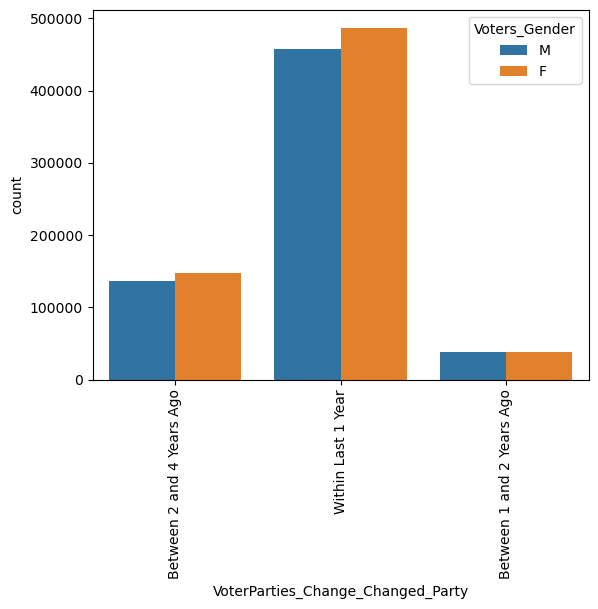

In [12]:
new_df = df.select("LALVOTERID", "Voters_Gender", "Voters_Active", "VoterParties_Change_Changed_Party", "MaritalStatus_Description")

new_df.filter(df.Voters_Active == "A").filter(df.MaritalStatus_Description == "Married").na.drop().show()

new_df = new_df.toPandas()


sns.countplot(x='VoterParties_Change_Changed_Party', hue = "Voters_Gender", data = new_df)

plt.xticks(rotation = 90, fontsize = 10)

plt.show()

### Logistic Regression

In [ ]:
al_new = alabama.select('Voters_Gender', 'Voters_Age', 'CommercialData_Education','ElectionReturns_G16_Cnty_Vote_Trump_R','ElectionReturns_G16_Cnty_Vote_Clinton_D') .na.drop(subset = ['Voters_Gender','Voters_Age','CommercialData_Education','ElectionReturns_G16_Cnty_Vote_Trump_R','ElectionReturns_G16_Cnty_Vote_Clinton_D'])


import pyspark.sql.functions as f

from pyspark.sql.types import IntegerType,BooleanType,DateType

al_new = al_new.withColumn("ElectionReturns_G16_Cnty_Vote_Trump_R",al_new.ElectionReturns_G16_Cnty_Vote_Trump_R.cast(IntegerType()))

al_new = al_new.withColumn("ElectionReturns_G16_Cnty_Vote_Clinton_D",al_new.ElectionReturns_G16_Cnty_Vote_Clinton_D.cast(IntegerType()))

al_new = al_new.withColumn('VoteRepub', al_new['ElectionReturns_G16_Cnty_Vote_Trump_R'] > al_new['ElectionReturns_G16_Cnty_Vote_Clinton_D'])


al_new.printSchema()

al_new = al_new.withColumn("County_Swing", f.when(f.col("VoteRepub") == True, "Republican").otherwise("Democrat")).show()

In [ ]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="Voters_Gender ~  Voters_Active + VoterParties_Change_Changed_Party + MaritalStatus_Description+ ElectionReturns_G16_Cnty_Vote_Trump_R + ElectionReturns_G16_Cnty_Vote_Clinton_D" )

In [ ]:
new1_df = df.select("Voters_Gender", "Voters_Active", "VoterParties_Change_Changed_Party", "MaritalStatus_Description","ElectionReturns_G16_Cnty_Vote_Trump_R","ElectionReturns_G16_Cnty_Vote_Clinton_D")


In [ ]:
fittedRF = supervised.fit(new1_df)  # fit the transformer
preparedDF = fittedRF.transform(new1_df)  # transform
preparedDF.show(5, False)

### For parquet Alabama